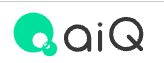

[disclaimer](../disclaimer.txt/)

# Data Handler

This component is responsible for retrieving and storing data from a database.  <br>
It includes functionalities for processing the stored data to create new features and for visualizing the data in graphs.

## 0. Preparation

In [1]:
# Import the libraries needed for the sample.
import os
import pandas as pd

### Import the Data Handler (DAL)

In [2]:
from aiq_strategy_robot.data.data_accessor import DAL
sdh = DAL()

### Import helper functions

When loading data from data sources (e.g., **factset**, **finnhub**), the handler's helper functions are used.<br>
Below, we import the helper functions used in this sample.

In [3]:
from aiq_strategy_robot.data.FINNHUB import (
    load_finnhub_symbol_lookup,
    load_finnhub_fundamental, 
    load_finnhub_equity_data, 
)

from aiq_strategy_robot.data.ALTERNATIVE import (
    load_alternative_aiq_pos_csmr_goods_universe, 
    load_alternative_aiq_pos_csmr_goods_data
)

## 1. symbol_lookup

This is the endpoint used to look up the symbol codes of each data vendor from the general Bloomberg ticker codes.

In [4]:
# Example: `finnhub loader`'s `symbol_lookup`
tickers = ['4661 JP', '9983 JP', 'AAPL US']

df_symbols_finnhub = load_finnhub_symbol_lookup(sdh, exchange_code='T', tickers=['4661 JP', '9983 JP', 'AAPL US']).retrieve()
display(df_symbols_finnhub.head())

,currency,description,displaySymbol,figi,isin,mic,shareClassFIGI,symbol,symbol2,type,TICKER
0,JPY,ORIENTAL LAND CO LTD,4661.T,BBG000HPZ220,None,XJPX,BBG001S9BPK7,4661.T,,Common Stock,4661 JP
1,JPY,FAST RETAILING CO LTD,9983.T,BBG000CLY9R3,None,XJPX,BBG001S82FV9,9983.T,,Common Stock,9983 JP
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL.T,NaN,NaN,AAPL US


### Retrieve symbols that exist in both alternative data and Finnhub. 

#### Get the universe of aiQ POS csmr goods from alternative data.

In [5]:
ENV_DATABSE = 'TRIAL_SNOWFLAKE_DATABASE_AIQ_POS_CSMR_GOODS'
db_name = os.environ.get(ENV_DATABSE)

In [6]:
sdh = DAL()
aiq_pos_universe = load_alternative_aiq_pos_csmr_goods_universe(sdh, db_name=db_name).retrieve()
aiq_pos_universe.head()

,FIGI,TICKER
0,BBG000BLHMK1,2818
1,BBG002PCB6N0,2883
2,BBG0046L16R4,3863
3,BBG000BJHXZ6,4218
4,BBG000BK8R59,2813


#### Retrieve Finnhub symbols
Obtain Finnhub symbols using the Ticker from the `aiQ POS csmr goods` universe.

In [7]:
# Retrieve Symbols
df_symbols_finnhub = load_finnhub_symbol_lookup(sdh, exchange_code='T', tickers=(aiq_pos_universe.TICKER + ' JP').to_list()).retrieve()

Extract 6 samples as an example

In [8]:
num = 6
df_symbols_finnhub = df_symbols_finnhub.dropna(subset='currency').sample(num)
display(df_symbols_finnhub)

tickers = df_symbols_finnhub.TICKER.to_list()
alt_tickers = df_symbols_finnhub.TICKER.str.split(' ').str[0].to_list()
finnhub_symbols = df_symbols_finnhub.symbol.to_list()

,currency,description,displaySymbol,figi,isin,mic,shareClassFIGI,symbol,symbol2,type,TICKER
217,JPY,A&D HOLON HOLDINGS CO LTD,7745.T,BBG000CR4S00,None,XJPX,BBG001SGYHV2,7745.T,,Common Stock,7745 JP
7,JPY,NIPPN CORP,2001.T,BBG000BHFHG8,None,XJPX,BBG001S6C321,2001.T,,Common Stock,2001 JP
177,JPY,MIZUHO MEDY CO LTD,4595.T,BBG00BF107Z2,None,XJPX,BBG001TLC4W2,4595.T,,Common Stock,4595 JP
201,JPY,GODO STEEL LTD,5410.T,BBG000BL6KB7,None,XJPX,BBG001S6FDT7,5410.T,,Common Stock,5410 JP
253,JPY,HACHI-BAN CO LTD,9950.T,BBG000BHN520,None,XJPX,BBG001S7D4L5,9950.T,,Common Stock,9950 JP
237,JPY,ASTENA HOLDINGS CO LTD,8095.T,BBG000BPRBS7,None,XJPX,BBG001S6GVG0,8095.T,,Common Stock,8095 JP


## 2. Obtain stock prices

In [9]:
sdh = DAL()

# Obtain daily data
load_finnhub_equity_data(
    sdh,
    symbols=finnhub_symbols,
    freq='D',
    start_datetime='2010-01-01', 
    end_datetime='2024-01-01'
).retrieve().head()

8095.T: loading...: 100%|██████████| 6/6 [00:03<00:00,  1.55it/s]


close   high    low   open  volume  dividends  split_ratio
TICKER  DATETIME                                                              
7745 JP 2010-01-04  322.0  338.0  321.0  330.0   17500        0.0          1.0
        2010-01-05  326.0  331.0  321.0  330.0   21300        0.0          1.0
        2010-01-06  324.0  326.0  322.0  325.0   23500        0.0          1.0
        2010-01-07  325.0  328.0  321.0  324.0   19900        0.0          1.0
        2010-01-08  330.0  330.0  323.0  326.0   31500        0.0          1.0

In [10]:
# Obtain weekly data
load_finnhub_equity_data(
    sdh,
    symbols=finnhub_symbols,
    freq='W',
    start_datetime='2010-01-01', 
    end_datetime='2024-01-01'
).retrieve().head()

8095.T: loading...: 100%|██████████| 6/6 [00:03<00:00,  1.92it/s]


close   high    low   open    volume  dividends  \
TICKER  DATETIME                                                      
7745 JP 2010-01-04  330.0  338.0  321.0  330.0  113700.0        0.0   
        2010-01-12  354.0  354.0  330.0  335.0  234800.0        0.0   
        2010-01-18  340.0  379.0  335.0  355.0  392200.0        0.0   
        2010-01-25  332.0  370.0  330.0  341.0  279900.0        0.0   
        2010-02-01  321.0  349.0  310.0  324.0  181700.0        0.0   

                    split_ratio  
TICKER  DATETIME                 
7745 JP 2010-01-04          1.0  
        2010-01-12          1.0  
        2010-01-18          1.0  
        2010-01-25          1.0  
        2010-02-01          1.0

### Appendix

#### 1. Check the loaded data

The obtained data is registered with the handler, and each dataset is assigned a `data_id`.

In [11]:
sdh.extract_definition

,category,data_source,source,table,alias,tickers,index,start_datetime,end_datetime
data_id,,,,,,,,,
1,RawData,finnhub,equity_data,None,None,"[2001 JP, 4595 JP, 5410 JP, 7745 JP, 8095 JP, ...","[TICKER, DATETIME]",2010-01-04 00:00:00,2023-12-29 00:00:00
2,RawData,finnhub,equity_data,None,NaN,"[2001 JP, 4595 JP, 5410 JP, 7745 JP, 8095 JP, ...","[TICKER, DATETIME]",2010-01-04 00:00:00,2023-12-28 00:00:00


In [12]:
# Set aliases
sdh.set_alias({1: 'finhub_price_D', 2: 'finhub_price_W'})
sdh.extract_definition

,category,data_source,source,table,alias,tickers,index,start_datetime,end_datetime
data_id,,,,,,,,,
1,RawData,finnhub,equity_data,None,finhub_price_D,"[2001 JP, 4595 JP, 5410 JP, 7745 JP, 8095 JP, ...","[TICKER, DATETIME]",2010-01-04 00:00:00,2023-12-29 00:00:00
2,RawData,finnhub,equity_data,None,finhub_price_W,"[2001 JP, 4595 JP, 5410 JP, 7745 JP, 8095 JP, ...","[TICKER, DATETIME]",2010-01-04 00:00:00,2023-12-28 00:00:00


#### 2. Retrieve data immediately after loading with the `retrieve` method
The `retrieve` method can only obtain data that was loaded immediately before.


In [13]:
sdh.retrieve().tail()

close   high    low   open    volume  dividends  \
TICKER  DATETIME                                                      
8095 JP 2023-11-29    NaN    NaN    NaN    NaN       NaN        9.0   
        2023-12-04  476.0  492.0  476.0  492.0  582900.0        0.0   
        2023-12-11  470.0  481.0  468.0  480.0  496800.0        0.0   
        2023-12-18  469.0  473.0  462.0  468.0  521100.0        0.0   
        2023-12-25  476.0  476.0  463.0  471.0  392400.0        0.0   

                    split_ratio  
TICKER  DATETIME                 
8095 JP 2023-11-29          1.0  
        2023-12-04          1.0  
        2023-12-11          1.0  
        2023-12-18          1.0  
        2023-12-25          1.0

#### 3. Retrieve data using the `get_raw_data` method by specifying the `data_id`.
You can retrieve registered data using the `data_id`.

In [14]:
sdh.get_raw_data(2).tail()

close    high     low    open  volume  dividends  \
TICKER  DATETIME                                                        
9950 JP 2023-11-27  3270.0  3280.0  3260.0  3260.0  2900.0        0.0   
        2023-12-04  3270.0  3275.0  3260.0  3270.0  2800.0        0.0   
        2023-12-11  3300.0  3305.0  3270.0  3280.0  5400.0        0.0   
        2023-12-18  3280.0  3300.0  3275.0  3300.0  3700.0        0.0   
        2023-12-25  3295.0  3295.0  3280.0  3280.0  3300.0        0.0   

                    split_ratio  
TICKER  DATETIME                 
9950 JP 2023-11-27          1.0  
        2023-12-04          1.0  
        2023-12-11          1.0  
        2023-12-18          1.0  
        2023-12-25          1.0

## 3. Retrieval of Financial Data

In [15]:
load_finnhub_fundamental(
    sdh,
    symbols=finnhub_symbols,
    st_type='ic',         # `bs`, `ic`, `cf` for Balance Sheet, Income Statement
    freq='quarterly', 
    start_datetime='2010-01-01',  
    end_datetime='2024-01-01',
    with_calendar=False
).retrieve().head()

8095.T: loading...: 100%|██████████| 6/6 [00:00<00:00,  7.64it/s]


costOfGoodsSold  dilutedAverageSharesOutstanding  \
TICKER  DATETIME                                                       
7745 JP 2014-09-30           5056.0                             21.0   
        2014-12-31           5168.0                             21.0   
        2015-03-31           6652.0                             22.0   
        2015-06-30           4719.0                             21.0   
        2015-09-30           5177.0                             21.0   

                    dilutedEPS    ebit  gainLossOnDispositionOfAssets  \
TICKER  DATETIME                                                        
7745 JP 2014-09-30       -0.37   298.0                            0.0   
        2014-12-31       -2.33   541.0                            1.0   
        2015-03-31       29.18  1390.0                            6.0   
        2015-06-30      -22.23  -565.0                            6.0   
        2015-09-30        4.71   169.0                            1.0   

                    grossIncome  interestIncomeExpense  minorityInterest  \
TICKER  DATETIME                                                           
7745 JP 2014-09-30       4317.0                 -118.0             -36.0   
        2014-12-31       4753.0                 -558.0              -6.0   
        2015-03-31       5620.0                  -74.0              -5.0   
        2015-06-30       3566.0                   -5.0              -1.0   
        2015-09-30       4222.0                  -65.0               1.0   

                    netIncome  netIncomeAfterTaxes  nonRecurringItems  \
TICKER  DATETIME                                                        
7745 JP 2014-09-30       -8.0                 29.0               18.0   
        2014-12-31      -49.0                -44.0               -2.0   
        2015-03-31      642.0                648.0              -27.0   
        2015-06-30     -467.0               -466.0               -2.0   
        2015-09-30       99.0                 96.0               -1.0   

                    otherOperatingExpensesTotal  pretaxIncome  \
TICKER  DATETIME                                                
7745 JP 2014-09-30                          NaN          84.0   
        2014-12-31                          1.0         -24.0   
        2015-03-31                         -1.0        1335.0   
        2015-06-30                          1.0        -573.0   
        2015-09-30                         -2.0         136.0   

                    provisionforIncomeTaxes  revenue  sgaExpense  \
TICKER  DATETIME                                                   
7745 JP 2014-09-30                     55.0   9373.0      4019.0   
        2014-12-31                     20.0   9921.0      4211.0   
        2015-03-31                    687.0  12272.0      4231.0   
        2015-06-30                   -107.0   8285.0      4130.0   
        2015-09-30                     40.0   9399.0      4055.0   

                    totalOperatingExpense  totalOtherIncomeExpenseNet  \
TICKER  DATETIME                                                        
7745 JP 2014-09-30                 4019.0                      -114.0   
        2014-12-31                 4212.0                        -6.0   
        2015-03-31                 4230.0                        40.0   
        2015-06-30                 4131.0                        -7.0   
        2015-09-30                 4053.0                        32.0   

                    depreciationAmortization  
TICKER  DATETIME                              
7745 JP 2014-09-30                       NaN  
        2014-12-31                       NaN  
        2015-03-31                       NaN  
        2015-06-30                       NaN  
        2015-09-30                       NaN

In [16]:
load_finnhub_fundamental(
    sdh,
    symbols=finnhub_symbols,
    st_type='bs',         # `bs`, `ic`, `cf` for Balance Sheet, Income Statement
    freq='quarterly', 
    start_datetime='2010-01-01',  
    end_datetime='2024-01-01',
    with_calendar=False
).retrieve().head()

8095.T: loading...: 100%|██████████| 6/6 [00:00<00:00,  7.47it/s]


accountsPayable  accountsReceivables  accruedLiability  \
TICKER  DATETIME                                                             
7745 JP 2014-09-30           3485.0               9710.0             780.0   
        2014-12-31           4060.0              10400.0             407.0   
        2015-03-31           3808.0              12502.0             838.0   
        2015-06-30           3707.0              10225.0             447.0   
        2015-09-30           3795.0               9761.0             830.0   

                    additionalPaidInCapital  cashEquivalents  \
TICKER  DATETIME                                               
7745 JP 2014-09-30                   6404.0           6501.0   
        2014-12-31                   6404.0           8152.0   
        2015-03-31                   6404.0           6536.0   
        2015-06-30                   6402.0           6860.0   
        2015-09-30                   6402.0           6073.0   

                    cashShortTermInvestments  commonStock  currentAssets  \
TICKER  DATETIME                                                           
7745 JP 2014-09-30                    6501.0       6388.0        30995.0   
        2014-12-31                    8152.0       6388.0        33817.0   
        2015-03-31                    6536.0       6388.0        33181.0   
        2015-06-30                    6860.0       6388.0        31745.0   
        2015-09-30                    6073.0       6388.0        30848.0   

                    currentLiabilities  currentPortionLongTermDebt  ...  \
TICKER  DATETIME                                                    ...   
7745 JP 2014-09-30             22240.0                      2539.0  ...   
        2014-12-31             25204.0                      2615.0  ...   
        2015-03-31             23886.0                      2814.0  ...   
        2015-06-30             23751.0                      2661.0  ...   
        2015-09-30             23415.0                      2673.0  ...   

                    totalEquity  totalLiabilities  totalReceivables  \
TICKER  DATETIME                                                      
7745 JP 2014-09-30      14964.0           28142.0            9710.0   
        2014-12-31      14398.0           31757.0           10400.0   
        2015-03-31      15272.0           30512.0           12502.0   
        2015-06-30      14884.0           29976.0           10225.0   
        2015-09-30      14144.0           29741.0            9761.0   

                    treasuryStock  unrealizedProfitLossSecurity  \
TICKER  DATETIME                                                  
7745 JP 2014-09-30         -772.0                          10.0   
        2014-12-31         -772.0                          11.0   
        2015-03-31         -772.0                          12.0   
        2015-06-30         -772.0                          17.0   
        2015-09-30         -772.0                          12.0   

                    accumulatedDepreciation  deferredIncomeTax  \
TICKER  DATETIME                                                 
7745 JP 2014-09-30                      NaN                NaN   
        2014-12-31                      NaN                NaN   
        2015-03-31                      NaN                NaN   
        2015-06-30                      NaN                NaN   
        2015-09-30                      NaN                NaN   

                    longTermInvestments  shortTermInvestments  \
TICKER  DATETIME                                                
7745 JP 2014-09-30                  NaN                   NaN   
        2014-12-31                  NaN                   NaN   
        2015-03-31                  NaN                   NaN   
        2015-06-30                  NaN                   NaN   
        2015-09-30                  NaN                   NaN   

                    noteReceivableLongTerm  
TICKER  DATETIME                 

In [17]:
sdh.extract_definition

,category,data_source,source,table,alias,tickers,index,start_datetime,end_datetime
data_id,,,,,,,,,
1,RawData,finnhub,equity_data,None,finhub_price_D,"[2001 JP, 4595 JP, 5410 JP, 7745 JP, 8095 JP, ...","[TICKER, DATETIME]",2010-01-04 00:00:00,2023-12-29 00:00:00
2,RawData,finnhub,equity_data,None,finhub_price_W,"[2001 JP, 4595 JP, 5410 JP, 7745 JP, 8095 JP, ...","[TICKER, DATETIME]",2010-01-04 00:00:00,2023-12-28 00:00:00
3,RawData,finnhub,fundamental,None,None,"[2001 JP, 4595 JP, 5410 JP, 7745 JP, 8095 JP, ...","[TICKER, DATETIME]",2014-08-31 00:00:00,2023-12-31 00:00:00
4,RawData,finnhub,fundamental,None,NaN,"[2001 JP, 4595 JP, 5410 JP, 7745 JP, 8095 JP, ...","[TICKER, DATETIME]",2014-08-31 00:00:00,2023-12-31 00:00:00


In [18]:
sdh.set_alias({ 3: 'finhub_ic', 4: 'finhub_bs'})
sdh.extract_definition

,category,data_source,source,table,alias,tickers,index,start_datetime,end_datetime
data_id,,,,,,,,,
1,RawData,finnhub,equity_data,None,finhub_price_D,"[2001 JP, 4595 JP, 5410 JP, 7745 JP, 8095 JP, ...","[TICKER, DATETIME]",2010-01-04 00:00:00,2023-12-29 00:00:00
2,RawData,finnhub,equity_data,None,finhub_price_W,"[2001 JP, 4595 JP, 5410 JP, 7745 JP, 8095 JP, ...","[TICKER, DATETIME]",2010-01-04 00:00:00,2023-12-28 00:00:00
3,RawData,finnhub,fundamental,None,finhub_ic,"[2001 JP, 4595 JP, 5410 JP, 7745 JP, 8095 JP, ...","[TICKER, DATETIME]",2014-08-31 00:00:00,2023-12-31 00:00:00
4,RawData,finnhub,fundamental,None,finhub_bs,"[2001 JP, 4595 JP, 5410 JP, 7745 JP, 8095 JP, ...","[TICKER, DATETIME]",2014-08-31 00:00:00,2023-12-31 00:00:00


## 4. Retrieval of Alternative Data (aiQ POS csmr goods)

In [19]:
_sdh = DAL()

# generation=1
load_alternative_aiq_pos_csmr_goods_data(
    _sdh,
    generation=1,   # The generation of the data to retrieve.
    ticker=alt_tickers,
    variable = ['pos_sales', 'share', 'unit_price'],
    load_only_raw=True,
    load_only_latest=True, 
    db_name=db_name
).retrieve().head()

,TICKER,FIGI,DATETIME,VARIABLE,SMOOTH,VALUE,BACKFILL,RELEASE_TIMESTAMP
0,2001,BBG000BHFH50,2008-03-16,pos_sales,0,2.939286,1,2008-03-21 08:00:00
1,2001,BBG000BHFH50,2008-03-16,share,0,0.069128,1,2008-03-21 08:00:00
2,2001,BBG000BHFH50,2008-03-16,unit_price,0,0.874759,1,2008-03-21 08:00:00
3,2001,BBG000BHFH50,2008-03-23,pos_sales,0,2.916513,1,2008-03-27 08:00:00
4,2001,BBG000BHFH50,2008-03-23,share,0,0.070815,1,2008-03-27 08:00:00


In [20]:
# generation=2
load_alternative_aiq_pos_csmr_goods_data(
    _sdh,
    generation=2,   # The generation of the data to retrieve.
    ticker=alt_tickers,
    variable = ['sales', 'pos_sales', 'share', 'unit_price'],
    load_only_raw=True,
    load_only_latest=True, 
    db_name=db_name
).retrieve().head()

,TICKER,FIGI,DATETIME,VARIABLE,SMOOTH,VALUE,BACKFILL,RELEASE_TIMESTAMP
0,2001,BBG000BHFH50,2017-01-08,pos_sales,0,4.351070,1,2017-01-13 08:00:00
1,2001,BBG000BHFH50,2017-01-08,share,0,0.075611,1,2017-01-13 08:00:00
2,2001,BBG000BHFH50,2017-01-08,unit_price,0,1.001625,1,2017-01-13 08:00:00
3,2001,BBG000BHFH50,2017-01-15,pos_sales,0,5.212295,1,2017-01-19 08:00:00
4,2001,BBG000BHFH50,2017-01-15,share,0,0.079414,1,2017-01-19 08:00:00


In [21]:
_sdh.extract_definition

,category,data_source,source,table,alias,tickers,index,start_datetime,end_datetime
data_id,,,,,,,,,
1,RawData,alternative,aiq_pos_csmr_goods,data,data,None,None,None,None
2,RawData,alternative,aiq_pos_csmr_goods,data,data2,None,None,None,None


### Appendix: Data Registration

Data sources shaped in memory can be registered with the handler. When doing so, the index should be `['TICKER', 'DATETIME']`.

#### Process the alternative data obtained in step 4 for registration.

In [22]:
df_pos = _sdh.get_raw_data(2)
df_pos['TICKER'] = df_pos['TICKER'] + ' JP'
df_pos['DATETIME'] = pd.to_datetime(df_pos['DATETIME'])
df_pos = df_pos.set_index(['TICKER', 'DATETIME'])
df_pos = df_pos.pivot(columns='VARIABLE', values='VALUE')
df_pos.columns.name = ''
df_pos.tail()

pos_sales     share  unit_price
TICKER  DATETIME                                   
9950 JP 2024-08-25   0.055270  0.001272    1.383970
        2024-09-01   0.057602  0.001330    1.210103
        2024-09-08   0.047611  0.001235    1.236902
        2024-09-15   0.052024  0.001423    1.266976
        2024-09-22   0.049930  0.001368    1.110991

Register the data with the handler using `set_raw_data`.

In [23]:
data_id_alt = sdh.set_raw_data(
    data_source='aiq_pos_cmsr_goods',
    source='handmaid',
    dfraw=df_pos
)
sdh.set_alias({data_id_alt: 'cmsr_goods'})

display(sdh.get_raw_data(data_id_alt).tail())
display(sdh.extract_definition)

pos_sales     share  unit_price
TICKER  DATETIME                                   
9950 JP 2024-08-25   0.055270  0.001272    1.383970
        2024-09-01   0.057602  0.001330    1.210103
        2024-09-08   0.047611  0.001235    1.236902
        2024-09-15   0.052024  0.001423    1.266976
        2024-09-22   0.049930  0.001368    1.110991

,category,data_source,source,table,alias,tickers,index,start_datetime,end_datetime
data_id,,,,,,,,,
1,RawData,finnhub,equity_data,None,finhub_price_D,"[2001 JP, 4595 JP, 5410 JP, 7745 JP, 8095 JP, ...","[TICKER, DATETIME]",2010-01-04 00:00:00,2023-12-29 00:00:00
2,RawData,finnhub,equity_data,None,finhub_price_W,"[2001 JP, 4595 JP, 5410 JP, 7745 JP, 8095 JP, ...","[TICKER, DATETIME]",2010-01-04 00:00:00,2023-12-28 00:00:00
3,RawData,finnhub,fundamental,None,finhub_ic,"[2001 JP, 4595 JP, 5410 JP, 7745 JP, 8095 JP, ...","[TICKER, DATETIME]",2014-08-31 00:00:00,2023-12-31 00:00:00
4,RawData,finnhub,fundamental,None,finhub_bs,"[2001 JP, 4595 JP, 5410 JP, 7745 JP, 8095 JP, ...","[TICKER, DATETIME]",2014-08-31 00:00:00,2023-12-31 00:00:00
5,RawData,aiq_pos_cmsr_goods,handmaid,Unknown,cmsr_goods,"[2001 JP, 4595 JP, 5410 JP, 7745 JP, 8095 JP, ...","[TICKER, DATETIME]",2017-01-08 00:00:00,2024-09-22 00:00:00


### Selecting Data Sources

Choose the `data_id` to specify for subsequent data transformations and other operations.

In [24]:
data_id_funda = 3
data_id_alt = data_id_alt

## 5. Example of Transformation

Use the `sdh.transform` accessor to apply variable transformations to the retrieved data.

In [25]:
sdh.transform.clear()

# KPI
kpi = sdh.transform.resample(data_id=data_id_funda, fields='revenue', rule='Q', func='mean').fillna(method='ffill').variable_ids[0]

# Features
alt_W_shift_1_ids = sdh.transform.shift(data_id=data_id_alt, periods=1).resample(rule='Q', func='mean').log_diff(periods=4).diff(periods=1).variable_ids
alt_W_shift_2_ids = sdh.transform.shift(data_id=data_id_alt, periods=2).resample(rule='Q', func='mean').log_diff(periods=4).diff(periods=1).variable_ids
alt_W_shift_3_ids = sdh.transform.shift(data_id=data_id_alt, periods=3).resample(rule='Q', func='mean').log_diff(periods=4).diff(periods=1).variable_ids
alt_W_shift_4_ids = sdh.transform.shift(data_id=data_id_alt, periods=4).resample(rule='Q', func='mean').log_diff(periods=4).diff(periods=1).variable_ids
alt_W_shift_5_ids = sdh.transform.shift(data_id=data_id_alt, periods=5).resample(rule='Q', func='mean').log_diff(periods=4).diff(periods=1).variable_ids
alt_W_shift_6_ids = sdh.transform.shift(data_id=data_id_alt, periods=6).resample(rule='Q', func='mean').log_diff(periods=4).diff(periods=1).variable_ids
alt_W_shift_7_ids = sdh.transform.shift(data_id=data_id_alt, periods=7).resample(rule='Q', func='mean').log_diff(periods=4).diff(periods=1).variable_ids
alt_W_shift_8_ids = sdh.transform.shift(data_id=data_id_alt, periods=8).resample(rule='Q', func='mean').log_diff(periods=4).diff(periods=1).variable_ids

### Appendix

#### Check the List of Transformed Variables

Each variable subjected to transformation processing is assigned a unique `variable_id`.

In [26]:
sdh.transform.find_variables().tail()

,variable_id,data_id,data_source,source,table,field,ticker,reference_id,variable_type,method,params,process_id
variable_name,,,,,,,,,,,,
"CmsrGoods_Share_Shifted(008)_Resampled(Q|mean, origin=""start_day"")_LogDiff(004)",94,5,aiq_pos_cmsr_goods,handmaid,Unknown,"CmsrGoods_Share_Shifted(008)_Resampled(Q|mean,...",None,91.0,feature,log_diff,periods=4,33
"CmsrGoods_Unit_price_Shifted(008)_Resampled(Q|mean, origin=""start_day"")_LogDiff(004)",95,5,aiq_pos_cmsr_goods,handmaid,Unknown,CmsrGoods_Unit_price_Shifted(008)_Resampled(Q|...,None,92.0,feature,log_diff,periods=4,33
"CmsrGoods_Pos_sales_Shifted(008)_Resampled(Q|mean, origin=""start_day"")_LogDiff(004)_Diff(001)",96,5,aiq_pos_cmsr_goods,handmaid,Unknown,CmsrGoods_Pos_sales_Shifted(008)_Resampled(Q|m...,None,93.0,feature,diff,periods=1,34
"CmsrGoods_Share_Shifted(008)_Resampled(Q|mean, origin=""start_day"")_LogDiff(004)_Diff(001)",97,5,aiq_pos_cmsr_goods,handmaid,Unknown,"CmsrGoods_Share_Shifted(008)_Resampled(Q|mean,...",None,94.0,feature,diff,periods=1,34
"CmsrGoods_Unit_price_Shifted(008)_Resampled(Q|mean, origin=""start_day"")_LogDiff(004)_Diff(001)",98,5,aiq_pos_cmsr_goods,handmaid,Unknown,CmsrGoods_Unit_price_Shifted(008)_Resampled(Q|...,None,95.0,feature,diff,periods=1,34


#### Check the List of Method Chains

You can view the list of method chains, including the defined variables and the sequence of applied transformation processes.<br>
Each method chain is uniquely identified by a `process_id`.

In [27]:
dfmc = sdh.transform.show_method_chain(end_only=True, ret_df=True)

,data_id,variable_id,step_001,step_002,step_003,step_004
process_id,,,,,,
2,3,[2],"resample(rule=""Q"", func=""mean"", origin=""start_day"")","fillna(method=""ffill"")",,
6,5,"[12, 13, 14]",shift(periods=1),"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),diff(periods=1)
10,5,"[24, 25, 26]",shift(periods=2),"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),diff(periods=1)
14,5,"[36, 37, 38]",shift(periods=3),"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),diff(periods=1)
18,5,"[48, 49, 50]",shift(periods=4),"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),diff(periods=1)
22,5,"[60, 61, 62]",shift(periods=5),"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),diff(periods=1)
26,5,"[72, 73, 74]",shift(periods=6),"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),diff(periods=1)
30,5,"[84, 85, 86]",shift(periods=7),"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),diff(periods=1)
34,5,"[96, 97, 98]",shift(periods=8),"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),diff(periods=1)


Check the list of variables corresponding to the `process_id` key.

In [28]:
sdh.transform.find_process(dfmc.index[-1]).head()

,variable_id,data_id,data_source,source,table,field,ticker,reference_id,variable_type,method,params,process_id
variable_name,,,,,,,,,,,,
"CmsrGoods_Pos_sales_Shifted(008)_Resampled(Q|mean, origin=""start_day"")_LogDiff(004)_Diff(001)",96,5,aiq_pos_cmsr_goods,handmaid,Unknown,CmsrGoods_Pos_sales_Shifted(008)_Resampled(Q|m...,None,93,feature,diff,periods=1,34
"CmsrGoods_Share_Shifted(008)_Resampled(Q|mean, origin=""start_day"")_LogDiff(004)_Diff(001)",97,5,aiq_pos_cmsr_goods,handmaid,Unknown,"CmsrGoods_Share_Shifted(008)_Resampled(Q|mean,...",None,94,feature,diff,periods=1,34
"CmsrGoods_Unit_price_Shifted(008)_Resampled(Q|mean, origin=""start_day"")_LogDiff(004)_Diff(001)",98,5,aiq_pos_cmsr_goods,handmaid,Unknown,CmsrGoods_Unit_price_Shifted(008)_Resampled(Q|...,None,95,feature,diff,periods=1,34


#### Undo or Clear Processing

#### Check transformed data
Specify the `variable_id` to retrieve the transformed data.

In [29]:
display(sdh.get_variables(kpi).tail())
display(sdh.get_variables(alt_W_shift_1_ids).tail())

FinhubIc_Revenue_Resampled(Q|mean, origin="start_day")_Fillna(method="ffill")
TICKER  DATETIME                                                                                 
9950 JP 2022-12-31                                           1837.147                            
        2023-03-31                                           1707.111                            
        2023-06-30                                           1894.057                            
        2023-09-30                                           2056.061                            
        2023-12-31                                           1911.286

CmsrGoods_Pos_sales_Shifted(001)_Resampled(Q|mean, origin="start_day")_LogDiff(004)_Diff(001)  \
TICKER  DATETIME                                                                                                    
9950 JP 2023-09-30                                          -0.082854                                               
        2023-12-31                                          -0.100533                                               
        2024-03-31                                          -0.072739                                               
        2024-06-30                                          -0.017494                                               
        2024-09-30                                          -0.171970                                               

                    CmsrGoods_Share_Shifted(001)_Resampled(Q|mean, origin="start_day")_LogDiff(004)_Diff(001)  \
TICKER  DATETIME                                                                                                
9950 JP 2023-09-30                                          -0.096602                                           
        2023-12-31                                          -0.027028                                           
        2024-03-31                                          -0.077764                                           
        2024-06-30                                           0.038922                                           
        2024-09-30                                          -0.146950                                           

                    CmsrGoods_Unit_price_Shifted(001)_Resampled(Q|mean, origin="start_day")_LogDiff(004)_Diff(001)  
TICKER  DATETIME                                                                                                    
9950 JP 2023-09-30                                          -0.019593                                               
        2023-12-31                                           0.047554                                               
        2024-03-31                                           0.035126                                               
        2024-06-30                                          -0.066501                                               
        2024-09-30                                          -0.125082

> sortcut for `get_variables`

In [30]:
sdh.gd(alt_W_shift_1_ids).tail()

CmsrGoods_Pos_sales_Shifted(001)_Resampled(Q|mean, origin="start_day")_LogDiff(004)_Diff(001)  \
TICKER  DATETIME                                                                                                    
9950 JP 2023-09-30                                          -0.082854                                               
        2023-12-31                                          -0.100533                                               
        2024-03-31                                          -0.072739                                               
        2024-06-30                                          -0.017494                                               
        2024-09-30                                          -0.171970                                               

                    CmsrGoods_Share_Shifted(001)_Resampled(Q|mean, origin="start_day")_LogDiff(004)_Diff(001)  \
TICKER  DATETIME                                                                                                
9950 JP 2023-09-30                                          -0.096602                                           
        2023-12-31                                          -0.027028                                           
        2024-03-31                                          -0.077764                                           
        2024-06-30                                           0.038922                                           
        2024-09-30                                          -0.146950                                           

                    CmsrGoods_Unit_price_Shifted(001)_Resampled(Q|mean, origin="start_day")_LogDiff(004)_Diff(001)  
TICKER  DATETIME                                                                                                    
9950 JP 2023-09-30                                          -0.019593                                               
        2023-12-31                                           0.047554                                               
        2024-03-31                                           0.035126                                               
        2024-06-30                                          -0.066501                                               
        2024-09-30                                          -0.125082

## 6. Data Visualization

### Plot Line
For a specified target (ticker) KPI (y), draw a line plot for other variables (X).

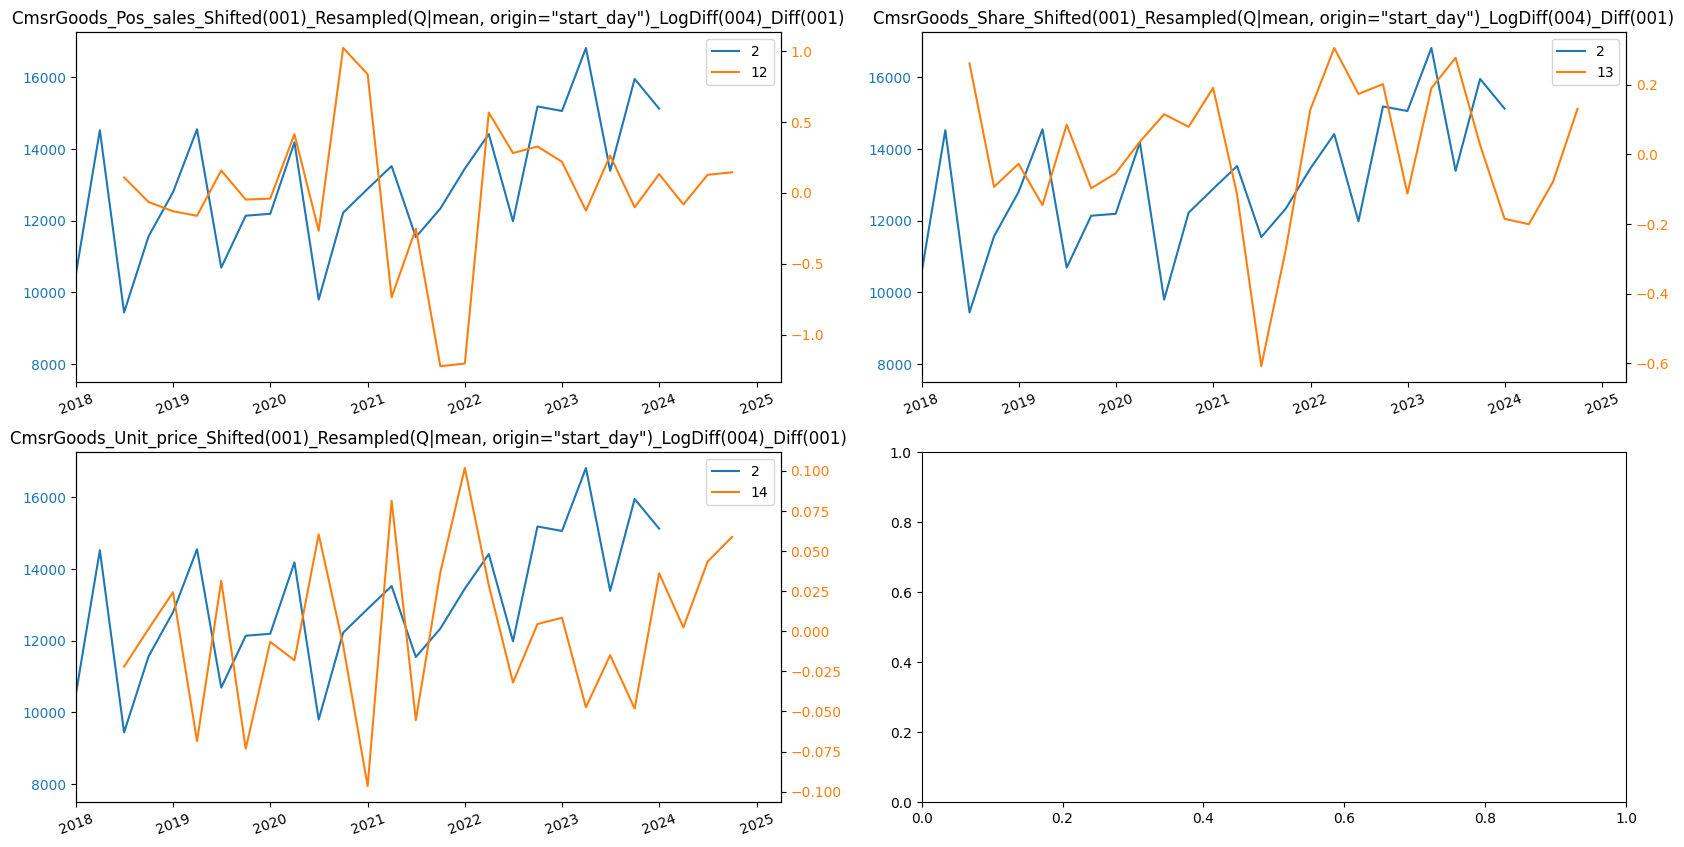

In [31]:
start_date='2018-01-01'

sdh.show_line_one_target(
    target=tickers[0],
    y=kpi,
    X=alt_W_shift_1_ids[:4],
    start_date=start_date,
    col_num=2,
    chunk_size=6,
)

For each target (ticker), draw a line plot of the KPI (y) and the variable (x).

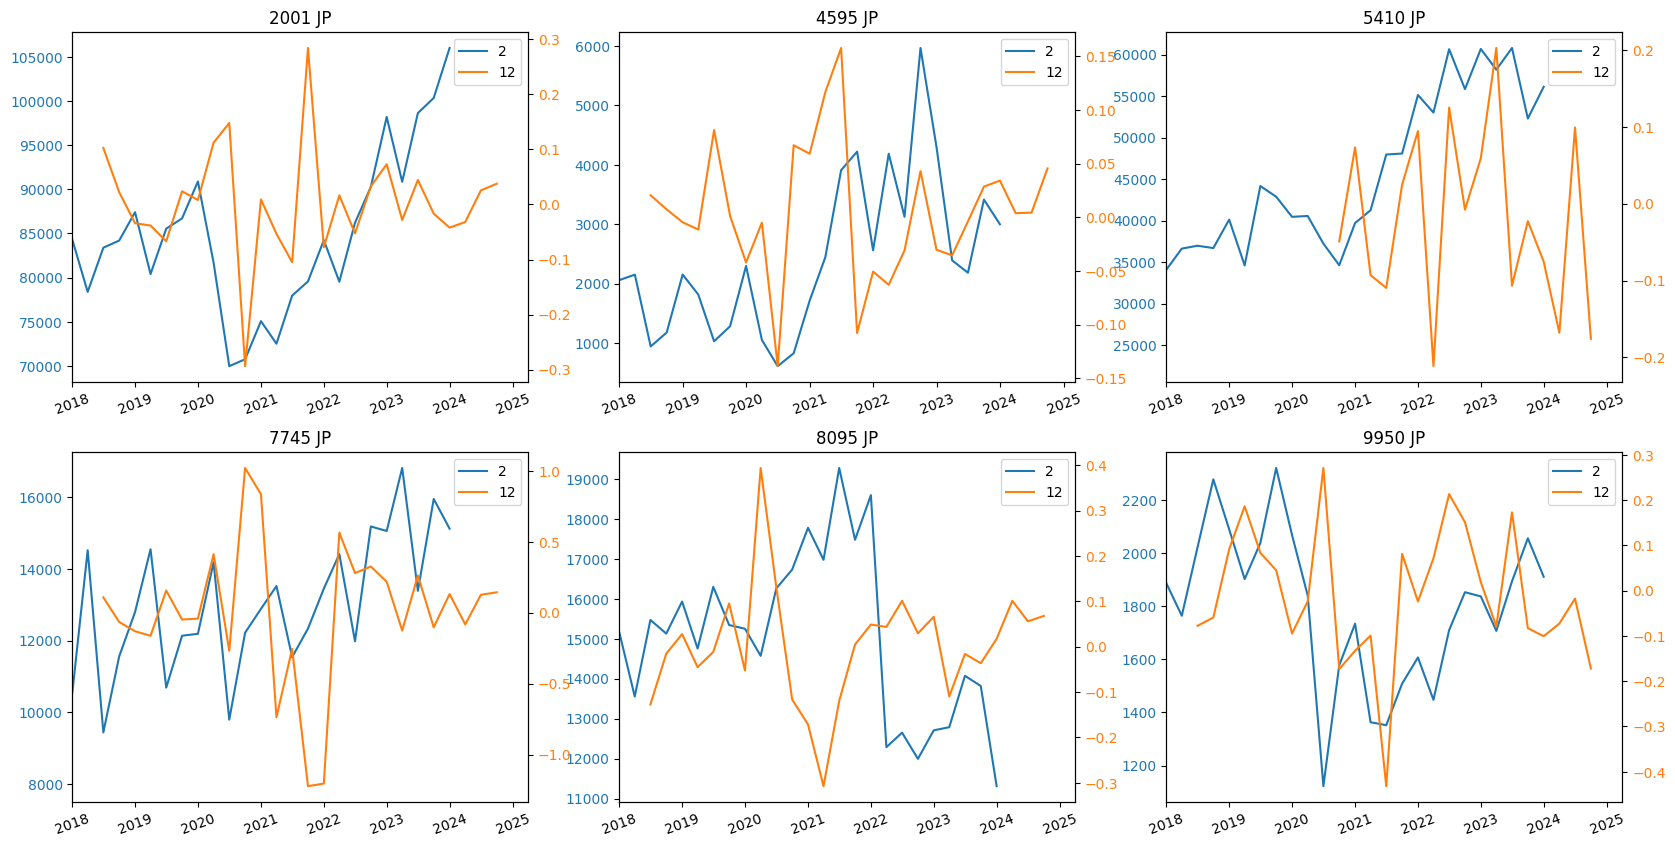

In [32]:
sdh.show_line_per_target(
    y=kpi,
    x=alt_W_shift_1_ids[0],
    # targets=tickers,
    start_date=start_date,
    col_num=3,
    chunk_size=6)


### Plot Scatter

Draw a scatter plot of the KPI (y) and other variables (X) for the specified target (ticker).

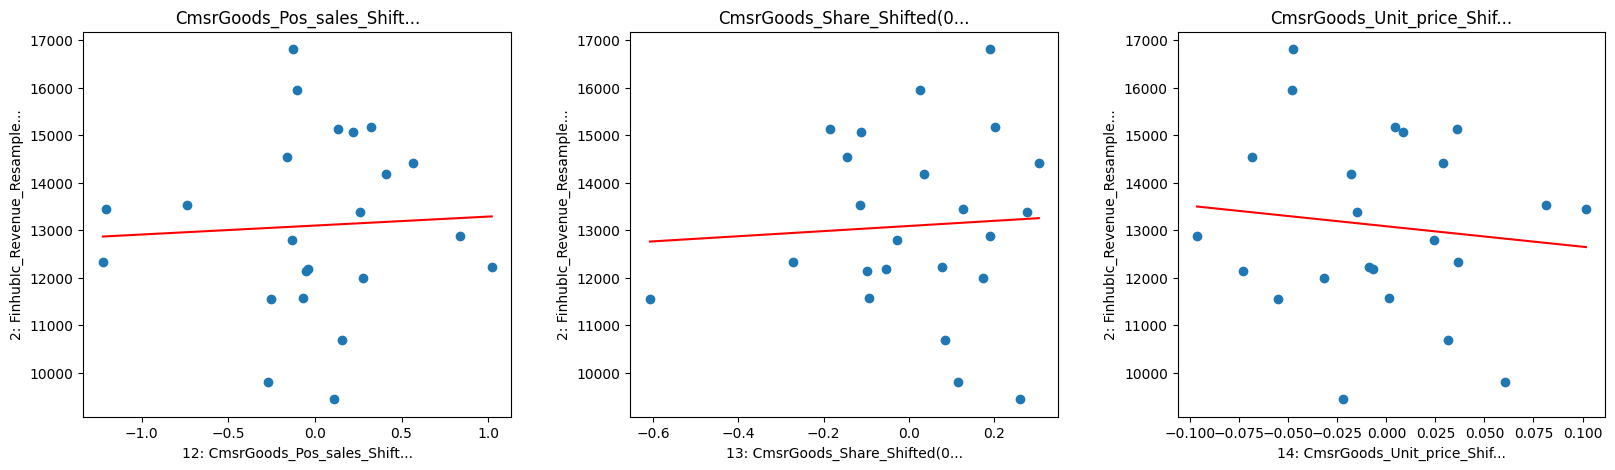

In [33]:
sdh.show_scatter_one_target(
    target=tickers[0],
    y=kpi,
    X=alt_W_shift_1_ids[-6:],
    start_date=start_date,
    col_num=3,
    vname_len_limit=25,
)

Draw scatter plots of the KPI (y) and variable (x) for each target (ticker).

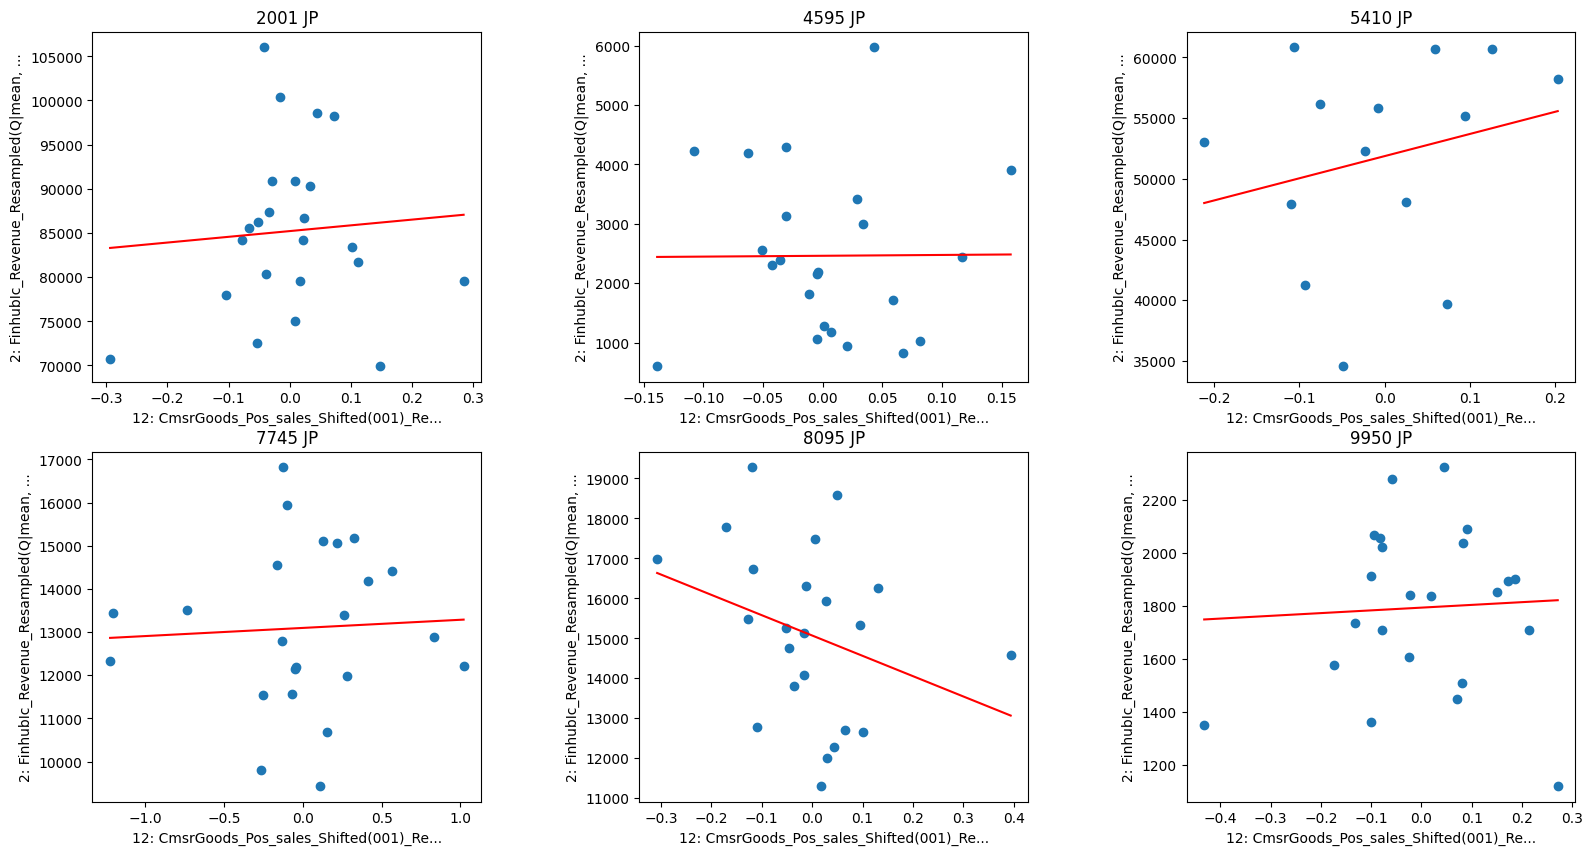

In [34]:
sdh.show_scatter_per_target(
    y=kpi,
    x=alt_W_shift_1_ids[0],
    # targets=tickers,
    start_date=start_date,
    col_num=3,
    vname_len_limit=35,
)